In [1]:
import torch.nn as nn
import torch
from PIL import Image
import numpy as np
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os

In [2]:
# Step 1
# Get the image and change every image to an 256-dimention vector
dataSet = np.zeros([10, 256])
for i in range(0, 10):
    inputImageDir = './input/' + str(i) + '.png'
    inputImage = Image.open(inputImageDir)
    inputImage = inputImage.convert("1")
    inputImage.save(inputImageDir)
    data = inputImage.getdata()
    array = np.array(data)/255
    dataSet[i] = array
dataSet = np.array(dataSet)

In [3]:
# Step 2
# define a neural network
class Perceptron(nn.Module):

    def __init__(self, input_size, num_hidden, num_classes):
        super(Perceptron, self).__init__()
        self.inputlayer = nn.Linear(input_size, num_hidden)
        self.hiddenlayer = nn.Linear(num_hidden, num_hidden)
        self.outputlayer = nn.Linear(num_hidden, num_classes)
        self.activate = nn.Sigmoid()

    def forward(self, x):
        res = self.inputlayer(x)
        res = self.activate(res)
        res = self.hiddenlayer(x)
        res = self.activate(res)
        res = self.outputlayer(x)
        res = self.activate(res)
        return res

In [4]:
class DigitDataset(Dataset):
    def __init__(self, dataset, label_list):
        self.dataset = dataset
        self.label_list = label_list
    def __len__(self):
        return len(self.label_list)
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.label_list[idx]
        return {
            'data': torch.from_numpy(data).float(),
            'label': torch.from_numpy(label).float()
        }

In [5]:
# Parameters of training
input_size = 256
num_classes = 256
num_hidden = 256
learning_rate = 0.001
batch_size = 10
num_epochs = 600

# Load the dataset
train_dataset = DigitDataset(dataset = dataSet, label_list = dataSet)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cpu')
model = Perceptron(input_size=input_size, num_hidden=num_hidden, num_classes=num_classes).to(device)

if not os.path.exists('./models'):
    os.mkdir('./models')
torch.save(model, './models/net_untrained.pkl')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [6]:
# Step 3
def train(dataloader, model, num_epochs):
    for epoch in range(num_epochs):
        losses = []
        ERROR_Train = [] 
        model.train() 
        for i, data in enumerate(dataloader, 0):
            model.zero_grad()
            real_cpu, label_cpu = data['data'], data['label']
#             if torch.cuda.is_available():
#                 real_cpu = real_cpu.cuda() 
#                 label_cpu = label_cpu.cuda()
            real = real_cpu
            label = label_cpu
            inputv = Variable(real)
            labelv = Variable(label)
            output = model(inputv)
            err = criterion(output, labelv) 
            err.backward() 
            optimizer.step() 

            losses.append(err.data.item())
            error = label - output.data
#             print(output.data)
#             print(error)
#             print(error.shape)
            ERROR_Train.extend(error)
        MAE = torch.mean(torch.abs(torch.stack(ERROR_Train)))
        ME = torch.mean(torch.stack(ERROR_Train))
        STD = torch.std(torch.stack(ERROR_Train)) 
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print('[%d/%d] Loss: %.4f MAE: %.4f Mean Error: %.4f STD: %.4f' % (epoch, num_epochs, np.average(losses), MAE, ME, STD))
            
    return output, model

# Start training        
output, model = train(train_loader, model, num_epochs)
# print(output.type)

[0/600] Loss: 0.2698 MAE: 0.5025 Mean Error: 0.4172 STD: 0.3094
[10/600] Loss: 0.0448 MAE: 0.1604 Mean Error: 0.1016 STD: 0.1856
[20/600] Loss: 0.0306 MAE: 0.0921 Mean Error: 0.0326 STD: 0.1720
[30/600] Loss: 0.0280 MAE: 0.0786 Mean Error: 0.0215 STD: 0.1659
[40/600] Loss: 0.0263 MAE: 0.0734 Mean Error: 0.0166 STD: 0.1613
[50/600] Loss: 0.0248 MAE: 0.0704 Mean Error: 0.0147 STD: 0.1567
[60/600] Loss: 0.0234 MAE: 0.0687 Mean Error: 0.0136 STD: 0.1523
[70/600] Loss: 0.0221 MAE: 0.0671 Mean Error: 0.0133 STD: 0.1481
[80/600] Loss: 0.0209 MAE: 0.0656 Mean Error: 0.0127 STD: 0.1440
[90/600] Loss: 0.0197 MAE: 0.0640 Mean Error: 0.0124 STD: 0.1400
[100/600] Loss: 0.0187 MAE: 0.0624 Mean Error: 0.0120 STD: 0.1362
[110/600] Loss: 0.0177 MAE: 0.0608 Mean Error: 0.0118 STD: 0.1325
[120/600] Loss: 0.0167 MAE: 0.0592 Mean Error: 0.0115 STD: 0.1289
[130/600] Loss: 0.0159 MAE: 0.0577 Mean Error: 0.0112 STD: 0.1255
[140/600] Loss: 0.0150 MAE: 0.0562 Mean Error: 0.0109 STD: 0.1221
[150/600] Loss: 0.014

In [7]:
# Step 4
# Step 4a
# Export the image after training
# Before executing this block, create a folder called "output"
if not os.path.exists('./output'):
    os.mkdir('./output')
output_np = output.detach().numpy()
print(output_np.shape)
torch.save(model, './models/net_trained.pkl')
output_dataset = np.zeros([10, 256])
for i in range(10):
    output_img = output_np[i].reshape(16, 16)*255
    img = Image.fromarray(np.uint8(output_img))
#     img = img.convert("1")
    threshold = 50
    img = img.point(lambda p: p > threshold and 255)
    output_path = './output/' + str(i) + '.png'
    img.save(output_path)
    data = img.getdata()
    array = np.array(data)/255
    output_dataset[i] = array

(10, 256)


In [8]:
# Step 4b
# Calculate Fh
def calculateFh(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Fh_denominator = 0    # Fh分母
    Fh_numerator = 0      # Fh分子
    Fh_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 0:
                Fh_denominator = Fh_denominator + 1
                if output_dataset[j][i] == 0:
                    Fh_numerator = Fh_numerator + 1
        Fh = Fh_numerator / Fh_denominator
        Fh_array[j] = Fh
    return Fh_array

In [9]:
# Calculate Ffa
def calculateFfa(input_dataset, output_dataset):
    x, y = input_dataset.shape
    Ffa_denominator = 0    # Ffa分母
    Ffa_numerator = 0      # Ffa分子
    Ffa_array = np.zeros([x])
    for j in range(x):
        for i in range(y):
            if input_dataset[j][i] == 1:
                Ffa_denominator = Ffa_denominator + 1
            if output_dataset[j][i] == 0 and input_dataset[j][i] == 1:
                Ffa_numerator = Ffa_numerator + 1
        Ffa = Ffa_numerator / Ffa_denominator
        Ffa_array[j] = Ffa
    return Ffa_array

In [10]:
Fh_array = calculateFh(dataSet, output_dataset)
Ffa_array = calculateFfa(dataSet, output_dataset)
print(Fh_array)
print(Ffa_array)

[0.96       0.97297297 0.98333333 0.96385542 0.97142857 0.96899225
 0.94805195 0.95266272 0.94897959 0.94570136]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
# TODO: Step 4c: Graph Fh as a function of Ffa for each exemplar in the input dataset

In [31]:
# Step 5
def gaussian_noise(img, mean, sigma):
    # Generate gauss noise
    noise = np.random.normal(mean, sigma, img.shape)
    # Add the noise to image
    gaussian_out = img + noise
    # Make the value between 0 and 1
    gaussian_out = np.clip(gaussian_out, 0, 1)
    return gaussian_out

gaussian_dataset = np.zeros([9, 10, 256])
std = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
if not os.path.exists('./input_noise/'):
    os.mkdir('./input_noise/')
for j in range(9):
    if not os.path.exists('./input_noise/' + str(std[j])):
        os.mkdir('./input_noise/' + str(std[j]))
    for i in range(10):
        inputImage = dataSet[i]
        gaussian_data = gaussian_noise(inputImage, 0, std[j])
        img = gaussian_data.reshape(16, 16)*255
        img = Image.fromarray(np.uint8(img))
        img.convert("1")
        inputImageDir = './input_noise/' + str(std[j]) + '/' + str(i) + '.png'
        img.save(inputImageDir)
        gaussian_dataset[j][i] = gaussian_data
gaussian_dataset = np.array(gaussian_dataset)


Fh_noise_array = np.zeros([9, 10])
Ffa_noise_array = np.zeros([9, 10])

# Train 9 datasets with noise
if not os.path.exists('./output_noise/'):
    os.mkdir('./output_noise/')
for j in range(9):
    train_noise_dataset = DigitDataset(dataset = gaussian_dataset[j], label_list = dataSet)
    train_noise_loader = DataLoader(dataset=train_noise_dataset, batch_size=batch_size, shuffle=False)
    print('Training dataset with noise standard deviation ' + str(std[j]))
#     model_noise = torch.load('./models/net_untrained.pkl') #  Load the model that trained before
    model_noise = Perceptron(input_size=input_size, num_hidden=num_hidden, num_classes=num_classes).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_noise.parameters(), lr=learning_rate)
    output_noise, model_noise = train(train_noise_loader, model_noise, num_epochs)   # Train
    torch.save(model_noise, './models/net_trained_' + str(std[j]) + '.pkl')
    model_noise = torch.load('./models/net_trained_' + str(std[j]) + '.pkl')
#     output_noise = model_noise(torch.from_numpy(gaussian_dataset[j]).float()) # Use the model trained before to test
    print('------------------------------------')
    output_noise = model_noise(torch.from_numpy(dataSet).float())
    output_noise_np = output_noise.detach().numpy()     # Get the output
#     print(output_noise_np)
    output_noise_dataset = np.zeros([10, 256])
#     Make the output only has 0 or 1
    
    if not os.path.exists('./output_noise/' + str(std[j])):
        os.mkdir('./output_noise/' + str(std[j]))
    for i in range(10):
        output_noise_img = output_noise_np[i].reshape(16, 16)*255
        img = Image.fromarray(np.uint8(output_noise_img))
#         img = img.convert("1")
        threshold = 50
        img = img.point(lambda p: p > threshold and 255)
        output_path = './output_noise/' + str(std[j]) + '/' + str(i) + '.png'
        img.save(output_path)
        data = img.getdata()
        array = np.array(data)/255
        output_noise_dataset[i] = array
#     Calculate Fh and Ffa
    Fh = calculateFh(dataSet, output_noise_dataset)
    Ffa = calculateFfa(dataSet, output_noise_dataset)
    Fh_noise_array[j] = Fh
    Ffa_noise_array[j] = Ffa
print('------------Fh_noise_array------------')
print(Fh_noise_array)
print('------------Ffa_noise_array------------')
print(Ffa_noise_array)

Training dataset with noise standard deviation 0.001
[0/600] Loss: 0.2554 MAE: 0.4905 Mean Error: 0.3995 STD: 0.3096
[10/600] Loss: 0.0429 MAE: 0.1552 Mean Error: 0.0941 STD: 0.1846
[20/600] Loss: 0.0306 MAE: 0.0903 Mean Error: 0.0330 STD: 0.1719
[30/600] Loss: 0.0281 MAE: 0.0777 Mean Error: 0.0195 STD: 0.1666
[40/600] Loss: 0.0264 MAE: 0.0733 Mean Error: 0.0168 STD: 0.1616
[50/600] Loss: 0.0249 MAE: 0.0709 Mean Error: 0.0148 STD: 0.1570
[60/600] Loss: 0.0235 MAE: 0.0689 Mean Error: 0.0138 STD: 0.1526
[70/600] Loss: 0.0221 MAE: 0.0673 Mean Error: 0.0133 STD: 0.1482
[80/600] Loss: 0.0209 MAE: 0.0657 Mean Error: 0.0127 STD: 0.1441
[90/600] Loss: 0.0198 MAE: 0.0640 Mean Error: 0.0123 STD: 0.1400
[100/600] Loss: 0.0187 MAE: 0.0624 Mean Error: 0.0120 STD: 0.1361
[110/600] Loss: 0.0176 MAE: 0.0607 Mean Error: 0.0117 STD: 0.1323
[120/600] Loss: 0.0167 MAE: 0.0591 Mean Error: 0.0115 STD: 0.1287
[130/600] Loss: 0.0158 MAE: 0.0575 Mean Error: 0.0112 STD: 0.1251
[140/600] Loss: 0.0149 MAE: 0.0560

[30/600] Loss: 0.0281 MAE: 0.0785 Mean Error: 0.0209 STD: 0.1664
[40/600] Loss: 0.0263 MAE: 0.0737 Mean Error: 0.0169 STD: 0.1614
[50/600] Loss: 0.0248 MAE: 0.0713 Mean Error: 0.0148 STD: 0.1569
[60/600] Loss: 0.0234 MAE: 0.0695 Mean Error: 0.0140 STD: 0.1524
[70/600] Loss: 0.0221 MAE: 0.0679 Mean Error: 0.0130 STD: 0.1481
[80/600] Loss: 0.0209 MAE: 0.0662 Mean Error: 0.0130 STD: 0.1439
[90/600] Loss: 0.0197 MAE: 0.0644 Mean Error: 0.0126 STD: 0.1398
[100/600] Loss: 0.0186 MAE: 0.0627 Mean Error: 0.0122 STD: 0.1359
[110/600] Loss: 0.0176 MAE: 0.0610 Mean Error: 0.0120 STD: 0.1320
[120/600] Loss: 0.0166 MAE: 0.0594 Mean Error: 0.0117 STD: 0.1283
[130/600] Loss: 0.0157 MAE: 0.0578 Mean Error: 0.0114 STD: 0.1247
[140/600] Loss: 0.0148 MAE: 0.0562 Mean Error: 0.0112 STD: 0.1212
[150/600] Loss: 0.0140 MAE: 0.0547 Mean Error: 0.0109 STD: 0.1179
[160/600] Loss: 0.0133 MAE: 0.0533 Mean Error: 0.0107 STD: 0.1147
[170/600] Loss: 0.0126 MAE: 0.0518 Mean Error: 0.0105 STD: 0.1117
[180/600] Loss: 0

[40/600] Loss: 0.0265 MAE: 0.0742 Mean Error: 0.0166 STD: 0.1619
[50/600] Loss: 0.0250 MAE: 0.0711 Mean Error: 0.0152 STD: 0.1574
[60/600] Loss: 0.0236 MAE: 0.0690 Mean Error: 0.0140 STD: 0.1530
[70/600] Loss: 0.0223 MAE: 0.0675 Mean Error: 0.0134 STD: 0.1487
[80/600] Loss: 0.0211 MAE: 0.0658 Mean Error: 0.0131 STD: 0.1445
[90/600] Loss: 0.0199 MAE: 0.0643 Mean Error: 0.0127 STD: 0.1405
[100/600] Loss: 0.0188 MAE: 0.0627 Mean Error: 0.0123 STD: 0.1367
[110/600] Loss: 0.0178 MAE: 0.0611 Mean Error: 0.0119 STD: 0.1329
[120/600] Loss: 0.0168 MAE: 0.0595 Mean Error: 0.0116 STD: 0.1293
[130/600] Loss: 0.0159 MAE: 0.0579 Mean Error: 0.0113 STD: 0.1258
[140/600] Loss: 0.0151 MAE: 0.0564 Mean Error: 0.0110 STD: 0.1224
[150/600] Loss: 0.0143 MAE: 0.0550 Mean Error: 0.0108 STD: 0.1191
[160/600] Loss: 0.0136 MAE: 0.0535 Mean Error: 0.0105 STD: 0.1160
[170/600] Loss: 0.0129 MAE: 0.0522 Mean Error: 0.0103 STD: 0.1129
[180/600] Loss: 0.0122 MAE: 0.0508 Mean Error: 0.0100 STD: 0.1100
[190/600] Loss: 

[60/600] Loss: 0.0234 MAE: 0.0694 Mean Error: 0.0144 STD: 0.1524
[70/600] Loss: 0.0221 MAE: 0.0677 Mean Error: 0.0132 STD: 0.1482
[80/600] Loss: 0.0209 MAE: 0.0661 Mean Error: 0.0128 STD: 0.1441
[90/600] Loss: 0.0198 MAE: 0.0644 Mean Error: 0.0126 STD: 0.1401
[100/600] Loss: 0.0187 MAE: 0.0627 Mean Error: 0.0123 STD: 0.1362
[110/600] Loss: 0.0177 MAE: 0.0610 Mean Error: 0.0119 STD: 0.1324
[120/600] Loss: 0.0167 MAE: 0.0594 Mean Error: 0.0117 STD: 0.1288
[130/600] Loss: 0.0158 MAE: 0.0578 Mean Error: 0.0114 STD: 0.1252
[140/600] Loss: 0.0150 MAE: 0.0563 Mean Error: 0.0111 STD: 0.1218
[150/600] Loss: 0.0142 MAE: 0.0548 Mean Error: 0.0109 STD: 0.1185
[160/600] Loss: 0.0134 MAE: 0.0534 Mean Error: 0.0106 STD: 0.1153
[170/600] Loss: 0.0127 MAE: 0.0520 Mean Error: 0.0104 STD: 0.1122
[180/600] Loss: 0.0120 MAE: 0.0506 Mean Error: 0.0101 STD: 0.1093
[190/600] Loss: 0.0114 MAE: 0.0493 Mean Error: 0.0099 STD: 0.1065
[200/600] Loss: 0.0109 MAE: 0.0481 Mean Error: 0.0097 STD: 0.1038
[210/600] Loss

[90/600] Loss: 0.0192 MAE: 0.0643 Mean Error: 0.0131 STD: 0.1380
[100/600] Loss: 0.0180 MAE: 0.0624 Mean Error: 0.0127 STD: 0.1337
[110/600] Loss: 0.0169 MAE: 0.0606 Mean Error: 0.0124 STD: 0.1296
[120/600] Loss: 0.0159 MAE: 0.0589 Mean Error: 0.0121 STD: 0.1256
[130/600] Loss: 0.0149 MAE: 0.0571 Mean Error: 0.0118 STD: 0.1217
[140/600] Loss: 0.0140 MAE: 0.0555 Mean Error: 0.0116 STD: 0.1179
[150/600] Loss: 0.0132 MAE: 0.0539 Mean Error: 0.0113 STD: 0.1143
[160/600] Loss: 0.0124 MAE: 0.0523 Mean Error: 0.0111 STD: 0.1109
[170/600] Loss: 0.0117 MAE: 0.0508 Mean Error: 0.0108 STD: 0.1076
[180/600] Loss: 0.0110 MAE: 0.0494 Mean Error: 0.0106 STD: 0.1044
[190/600] Loss: 0.0104 MAE: 0.0480 Mean Error: 0.0104 STD: 0.1014
[200/600] Loss: 0.0098 MAE: 0.0467 Mean Error: 0.0101 STD: 0.0985
[210/600] Loss: 0.0093 MAE: 0.0454 Mean Error: 0.0099 STD: 0.0957
[220/600] Loss: 0.0087 MAE: 0.0442 Mean Error: 0.0097 STD: 0.0930
[230/600] Loss: 0.0083 MAE: 0.0430 Mean Error: 0.0095 STD: 0.0905
[240/600] L

In [13]:
# TODO: Step 6: Display Data from your Tests in Step 5

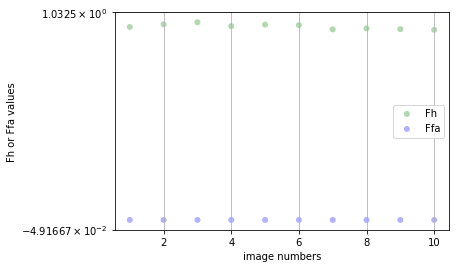

In [16]:
import numpy as np
import matplotlib.pyplot as plt

std_plot = [[i for _ in range(10)] for i in std]
# noiseless
fig, ax = plt.subplots()

ax.scatter([1,2,3,4,5,6,7,8,9,10], Fh_array, c="green",  label="Fh",alpha=0.3, edgecolors='none')
ax.scatter([1,2,3,4,5,6,7,8,9,10], Ffa_array, c="blue",  label="Ffa",alpha=0.3, edgecolors='none')
ax.legend()
ax.grid(True)
plt.xlabel("image numbers")
plt.ylabel("Fh or Ffa values")
plt.yscale("symlog")
plt.show()


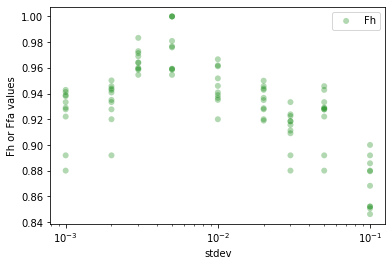

In [34]:
# noise
fig, ax = plt.subplots()
ax.scatter(std_plot, Fh_noise_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
# ax.scatter(std_plot, Ffa_noise_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
plt.xlabel("stdev")
plt.ylabel("Fh or Ffa values")
plt.xscale("log")
# plt.yscale("log")
ax.legend()
plt.show()

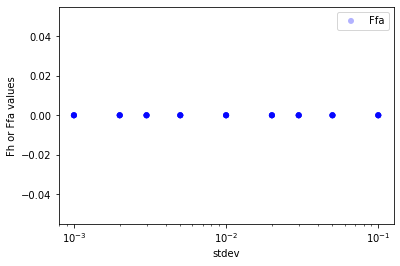

In [35]:
# noise
fig, ax = plt.subplots()
# ax.scatter(std_plot, Fh_noise_array, c="green", label="Fh", alpha=0.3, edgecolors='none')
ax.scatter(std_plot, Ffa_noise_array, c="blue", label="Ffa", alpha=0.3, edgecolors='none')
plt.xlabel("stdev")
plt.ylabel("Fh or Ffa values")
plt.xscale("log")
# plt.yscale("log")
ax.legend()
plt.show()

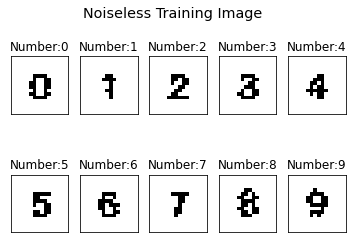

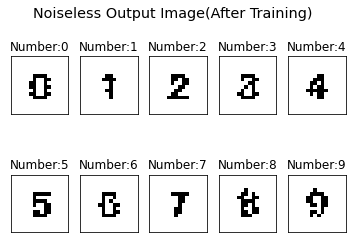

In [36]:
# display the image SMNN  NOiseless

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


N=2
M=5
#形成NxM大小的画布
fig = plt.figure()
st = fig.suptitle("Noiseless Training Image", fontsize="x-large")
for i in range(10):#有10张图片
    path='./input/' + str(i) + '.png'
    img = plt.imread(path)
    plt.subplot(N,M,i+1)#表示第i张图片，下标只能从1开始，不能从0，
    subplot_title=("Number:"+str(i))
    plt.title(subplot_title)
    plt.imshow(img,cmap="gray") #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
    plt.xticks([])
    plt.yticks([])
plt.show()

# Output Image display (Noiseless)

N=2
M=5
#形成NxM大小的画布
fig = plt.figure()
st = fig.suptitle("Noiseless Output Image(After Training)", fontsize="x-large")
for i in range(10):#有10张图片
    path='./output/' + str(i) + '.png'
    img = plt.imread(path)
    plt.subplot(N,M,i+1)#表示第i张图片，下标只能从1开始，不能从0，
    subplot_title=("Number:"+str(i))
    plt.title(subplot_title)
    plt.imshow(img,cmap="gray") #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
    plt.xticks([])
    plt.yticks([])
plt.show()

In [37]:
#  print Fh and Ffa as a table without noise
#!/usr/bin/python
#**coding:utf-8**
import sys
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Image(Number)','Fh','Ffa']

for i in range(10):
    table.add_row([i,Fh_array[i],round(Ffa_array[i],5)])
print(table)

+---------------+--------------------+-----+
| Image(Number) |         Fh         | Ffa |
+---------------+--------------------+-----+
|       0       |        0.96        | 0.0 |
|       1       | 0.972972972972973  | 0.0 |
|       2       | 0.9833333333333333 | 0.0 |
|       3       | 0.963855421686747  | 0.0 |
|       4       | 0.9714285714285714 | 0.0 |
|       5       | 0.9689922480620154 | 0.0 |
|       6       | 0.948051948051948  | 0.0 |
|       7       | 0.9526627218934911 | 0.0 |
|       8       | 0.9489795918367347 | 0.0 |
|       9       | 0.9457013574660633 | 0.0 |
+---------------+--------------------+-----+


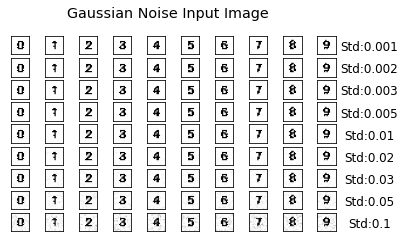

In [28]:
# Display the Input Image with Noise 
import matplotlib.pyplot as plt
import numpy as np

std = ['0.001', '0.002', '0.003', '0.005','0.01','0.02','0.03','0.05','0.1']
N=500
M=500
#形成NxM大小的画布
fig = plt.figure()
st = fig.suptitle("Gaussian Noise Input Image", fontsize="x-large")
k = 0
for j in std :
    for i in range(10):#有27张图片
        path='./input_noise/' + str(j) + '/' + str(i) + '.png'
        img = plt.imread(path)
        plt.subplot(10,10,(i+k)+1)#表示第i张图片，下标只能从1开始，不能从0，
        plt.imshow(img,cmap="gray")
        #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
        plt.xticks([])
        plt.yticks([])
        plt.subplot(10,10,k+5)
        subplot_title = ("Std:"+str(j))
        plt.title(subplot_title, x=12.08, y=-0.15)
    k = k + 10
plt.show()

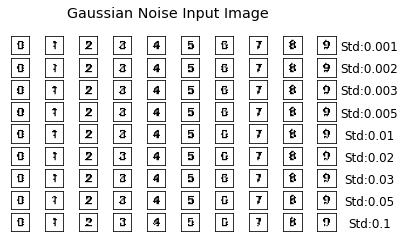

In [32]:
# Display the Onput Image with Noise 
import matplotlib.pyplot as plt
import numpy as np
std = ['0.001', '0.002', '0.003', '0.005','0.01','0.02','0.03','0.05','0.1']
N=100
M=100
#形成NxM大小的画布
fig = plt.figure()
st = fig.suptitle("Gaussian Noise Input Image", fontsize="x-large")
k = 0
for j in std :
    for i in range(10):#有27张图片
        path='./output_noise/' + str(j) + '/' + str(i) + '.png'
        img = plt.imread(path)
        plt.subplot(10,10,(i+k)+1)#表示第i张图片，下标只能从1开始，不能从0，
        plt.imshow(img,cmap="gray")
        #下面两行是消除每张图片自己单独的横纵坐标，不然每张图片会有单独的横纵坐标，影响美观
        plt.xticks([])
        plt.yticks([])
        plt.subplot(10,10,k+5)
        subplot_title = ("Std:"+str(j))
        plt.title(subplot_title, x=12.08, y=-0.15)
    k = k + 10
plt.show()

In [33]:
# displaying the fh and ffa as a table with NOISE
'''
NOTE: the table will be very big. For better displaying, please run the code in Pycharm.

'''


from prettytable import PrettyTable
table = PrettyTable()
[0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
table.field_names = ['Number','Stdev=0.001','Stdev=0.002','Stdev=0.003','Stdev=0.005','Stdev=0.01','Stdev=0.02','Stdev=0.03','Stdev=0.05','Stdev=0.1']

image_index = 0
for j in range(10):
    for i in range(1):
        table.add_row([image_index,
                   'fh:'+str(Fh_noise_array[i][j])+' ffa:'+str(round(Ffa_noise_array[i][j],4)),
                  'fh:'+str(Fh_noise_array[i+1][j])+' ffa:'+str(round(Ffa_noise_array[i+1][j],4)),
                   'fh:'+str(Fh_noise_array[i+2][j])+' ffa:'+str(round(Ffa_noise_array[i+2][j],4)),
                   'fh:'+str(Fh_noise_array[i+3][j])+' ffa:'+str(round(Ffa_noise_array[i+3][j],4)),
                   'fh:'+str(Fh_noise_array[i+4][j])+' ffa:'+str(round(Ffa_noise_array[i+4][j],4)),
                   'fh:'+str(Fh_noise_array[i+5][j])+' ffa:'+str(round(Ffa_noise_array[i+5][j],4)),
                   'fh:'+str(Fh_noise_array[i+6][j])+' ffa:'+str(round(Ffa_noise_array[i+6][j],4)),
                   'fh:'+str(Fh_noise_array[i+7][j])+' ffa:'+str(round(Ffa_noise_array[i+7][j],4)),
                   'fh:'+str(Fh_noise_array[i+8][j])+' ffa:'+str(round(Ffa_noise_array[i+8][j],4))
                  ])
    image_index += 1
print(table)

+--------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+
| Number |          Stdev=0.001          |          Stdev=0.002          |          Stdev=0.003          |          Stdev=0.005          |           Stdev=0.01          |           Stdev=0.02          |           Stdev=0.03          |           Stdev=0.05          |           Stdev=0.1           |
+--------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+-------------------------------+
|   0    |        fh:0.88 ffa:0.0        |        fh:0.92 ffa:0.0        |        fh:0.96 ffa:0.0      

In [38]:
Fh_array

array([0.96      , 0.97297297, 0.98333333, 0.96385542, 0.97142857,
       0.96899225, 0.94805195, 0.95266272, 0.94897959, 0.94570136])

In [39]:
Ffa_array

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [40]:
Fh_noise_array

array([[0.88      , 0.89189189, 0.93333333, 0.92771084, 0.94285714,
        0.9379845 , 0.92207792, 0.92899408, 0.93877551, 0.94117647],
       [0.92      , 0.89189189, 0.93333333, 0.92771084, 0.94285714,
        0.94573643, 0.93506494, 0.9408284 , 0.94387755, 0.95022624],
       [0.96      , 0.97297297, 0.98333333, 0.96385542, 0.97142857,
        0.96899225, 0.95454545, 0.95857988, 0.96428571, 0.95927602],
       [1.        , 1.        , 1.        , 0.97590361, 0.98095238,
        0.97674419, 0.95454545, 0.95857988, 0.95918367, 0.95927602],
       [0.92      , 0.94594595, 0.96666667, 0.95180723, 0.96190476,
        0.96124031, 0.93506494, 0.9408284 , 0.93877551, 0.93665158],
       [0.92      , 0.91891892, 0.95      , 0.92771084, 0.94285714,
        0.94573643, 0.92857143, 0.93491124, 0.94387755, 0.93665158],
       [0.88      , 0.89189189, 0.93333333, 0.91566265, 0.92380952,
        0.92248062, 0.90909091, 0.9112426 , 0.91836735, 0.91855204],
       [0.88      , 0.89189189, 0.9333333

In [41]:
Ffa_noise_array

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])